 **Импортируем необходимые библиотеки**

In [1]:
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Загружаем датасет iris.data**

In [3]:
data=[]
labels=[]

with open('/content/drive/MyDrive/iris.data','r') as f:
  for line in f:
    parts=line.strip().split(',')
    if len(parts)==5:
      features=list(map(float,parts[:4]))
      label=parts[4]
      data.append(features)
      labels.append(label)

X=np.array(data)
y=np.array(labels)
X_raw=X.copy()

print("Форма X:", X.shape)
print("Форма y:", y.shape)
print(f"Размер X в байтах: {X.nbytes}")
print(f"Размер y в байтах: {y.nbytes}")
print(f"\nПример строк X: {X[:3]}")
print(f"\nПример строк y: {y[:3]}")

Форма X: (150, 4)
Форма y: (150,)
Размер X в байтах: 4800
Размер y в байтах: 9000

Пример строк X: [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]

Пример строк y: ['Iris-setosa' 'Iris-setosa' 'Iris-setosa']



Вручную загрузил датасет Iris из файла `iris.data`.  
Признаки цветов сохраненил в матрице `X` формы `(n, 4)`,  
а названия видов ирисов — в векторе `y` размера `n`.

Также отобразил объём занимаемой памяти:
- `X`: вещественная матрица — занимает `X.nbytes` байт.
- `y`: массив строк — `y.nbytes` байт.

**Нормализация признаков**

In [4]:
X_min=X.min(axis=0)
X_max=X.max(axis=0)

X_norm=(X-X_min)/(X_max-X_min)

Каждый признак был масштабирован на интервал [0, 1] с использованием формулы:

$[
X_{\text{norm}} = \frac{X - \min(X)}{\max(X) - \min(X)}
$\]

Проверили, что минимум и максимум каждого столбца действительно 0 и 1 соответственно.

**Преобразование признака в категориальный**

In [5]:
feature = X_norm[:, 0]
q1, q3 = np.quantile(feature, [0.25, 0.75])

categories = np.empty_like(feature, dtype='<U6')
categories[feature < q1] = 'small'
categories[(feature >= q1) & (feature <= q3)] = 'medium'
categories[feature > q3] = 'big'

unique, counts = np.unique(categories, return_counts=True)
category_distribution=dict(zip(unique, counts))
print("Категориальное распределение квантилизации:",category_distribution)

Категориальное распределение квантилизации: {np.str_('big'): np.int64(35), np.str_('medium'): np.int64(83), np.str_('small'): np.int64(32)}


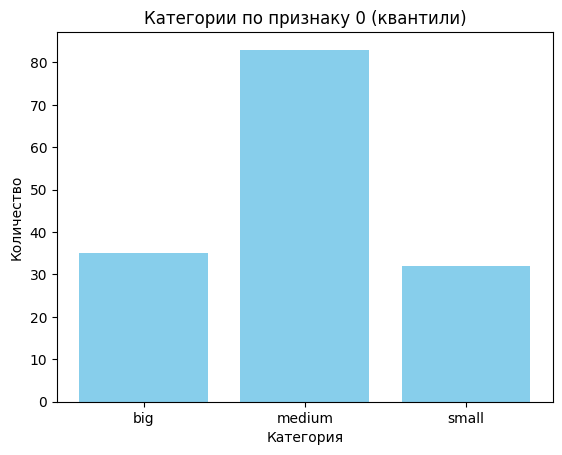

In [6]:
import matplotlib.pyplot as plt

plt.bar(unique, counts, color='skyblue')
plt.title("Категории по признаку 0 (квантили)")
plt.xlabel("Категория")
plt.ylabel("Количество")
plt.show()

Я выбрал 1-й признак (длину чашелистика) и разбил его значения по квартилям:

- `< 0.25` — категория **small**
- `0.25–0.75` — категория **medium**
- `> 0.75` — категория **big**

Получил категориальный вектор с распределением по трём классам.

**Разделение на обучающую и тестовую выборку**

In [7]:
np.random.seed(42)
indices = np.random.permutation(len(X_norm))
split_idx = int(0.8 * len(X_norm))

train_idx = indices[:split_idx]
test_idx = indices[split_idx:]

X_train = X_norm[train_idx]
X_test = X_norm[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

X_train_raw=X_raw[train_idx]
X_test_raw=X_raw[test_idx]

Случайным образом разделил нормализованный датасет в пропорции:
- 80% — тренировочная выборка (используется для обучения модели)
- 20% — тестовая выборка (используется для оценки качества)

Индексы перемешаны с фиксированным `random seed` для воспроизводимости.

**Импортируем необходимые библиотеки**

In [8]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

**Обучение базовой модели SVC**

In [9]:
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Точность на тестовой выборке:", acc)
print("Отчет классификации:\n", classification_report(y_test, y_pred))

Точность на тестовой выборке: 0.9666666666666667
Отчет классификации:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.92      1.00      0.96        11
 Iris-virginica       1.00      0.92      0.96        12

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30




Мы обучаем SVC (Support Vector Classifier) с параметрами по умолчанию.
Это модель, которая ищет гиперплоскость, разделяющую классы в пространстве признаков.

**Проведем эксперименты с гиперпараметрами**

In [10]:
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, y_train)
print("Linear kernel accuracy:", accuracy_score(y_test, svc_linear.predict(X_test)))

Linear kernel accuracy: 0.9666666666666667


In [11]:
svc_c10 = SVC(C=10)
svc_c10.fit(X_train, y_train)
print("C=10 accuracy:", accuracy_score(y_test, svc_c10.predict(X_test)))

C=10 accuracy: 1.0


In [12]:
svc_raw = SVC()
svc_raw.fit(X_train_raw, y_train)
print("Без нормализации accuracy:", accuracy_score(y_test, svc_raw.predict(X_test_raw)))

Без нормализации accuracy: 0.9666666666666667


SVM имеет чувствительные параметры:

- `kernel='linear'`: меняем ядро с радиального на линейное — это влияет на форму границы раздела между классами.
- `C=10`: увеличиваем "штраф" за ошибочную классификацию. Это делает модель более жесткой к ошибкам.
- Также обучаем модель **без нормализации признаков**, чтобы понять важность масштабирования входных данных.

**Визуализация (PCA и t-SNE) только на тестовой выборке**

In [13]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_test)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

tsne = TSNE(n_components=2, random_state=42, perplexity=25)
X_tsne = tsne.fit_transform(X_test)

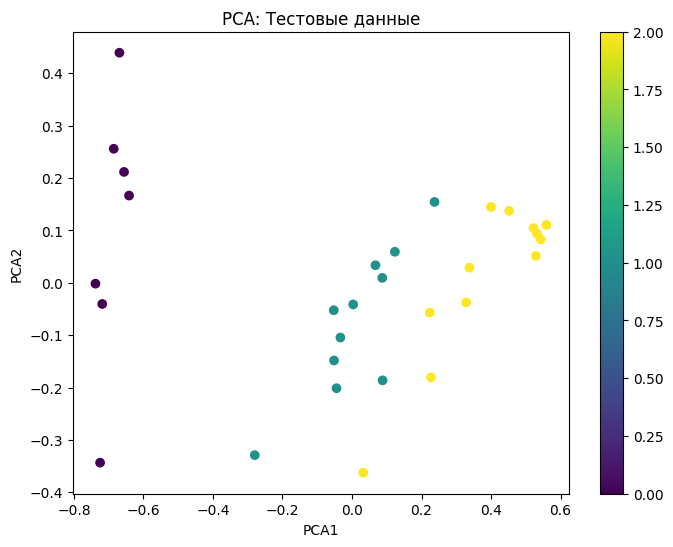

In [14]:
plt.figure(figsize=(8, 6))
scatter_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis')
plt.title('PCA: Тестовые данные')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(scatter_pca)
plt.show()

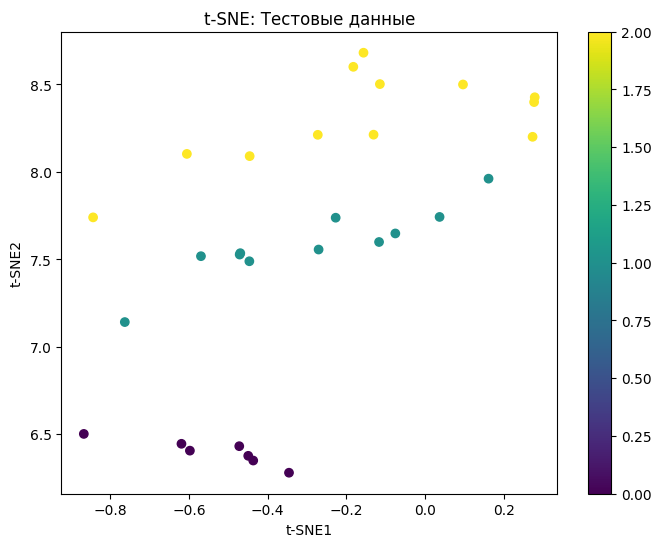

In [15]:
plt.figure(figsize=(8, 6))
scatter_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis')
plt.title('t-SNE: Тестовые данные')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.colorbar(scatter_tsne)
plt.show()

Чтобы понять, как тестовые данные распределяются в пространстве признаков,
мы уменьшаем размерность до 2 с помощью:

- **PCA (Principal Component Analysis)** — линейное преобразование, сохраняющее максимум дисперсии;
- **t-SNE (t-distributed Stochastic Neighbor Embedding)** — более сложное и нелинейное, акцент на локальной структуре.

Каждая точка на графике — один образец, цвет соответствует метке класса.

**Визуализация всего датасета (PCA и t-SNE)**

In [16]:
y_encoded_all = encoder.fit_transform(y)

pca_all = PCA(n_components=2)
X_pca_all = pca_all.fit_transform(X_norm)

tsne_all = TSNE(n_components=2, random_state=42, perplexity=25)
X_tsne_all = tsne_all.fit_transform(X_norm)

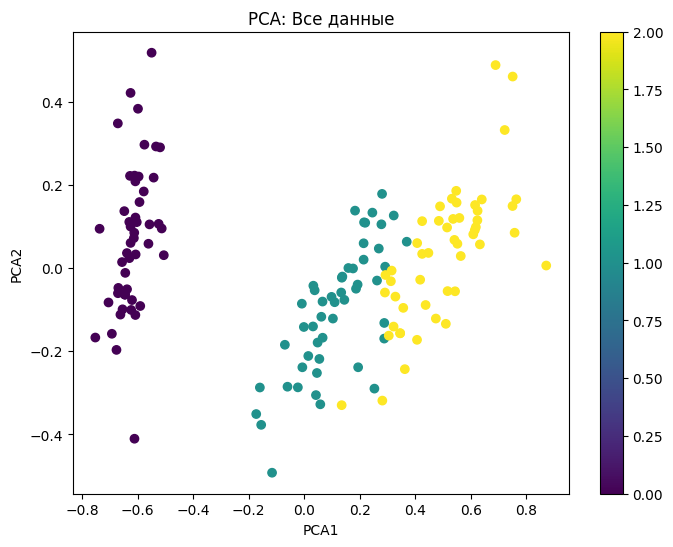

In [17]:
plt.figure(figsize=(8, 6))
scatter_pca_all = plt.scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=y_encoded_all, cmap='viridis')
plt.title('PCA: Все данные')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(scatter_pca_all)
plt.show()

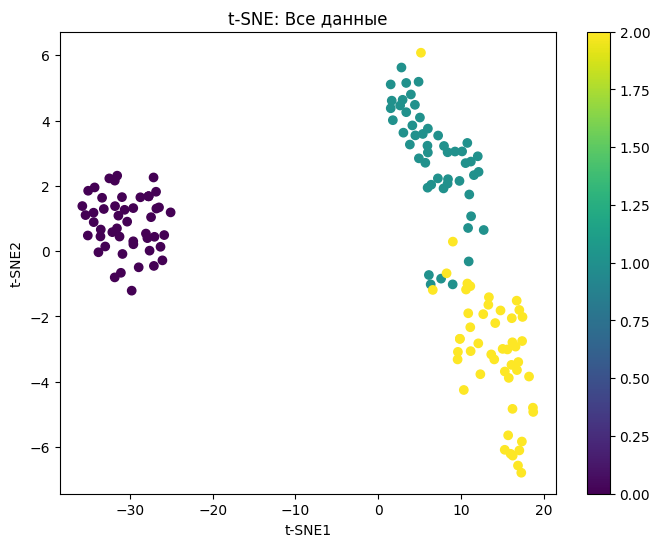

In [18]:
plt.figure(figsize=(8, 6))
scatter_tsne_all = plt.scatter(X_tsne_all[:, 0], X_tsne_all[:, 1], c=y_encoded_all, cmap='viridis')
plt.title('t-SNE: Все данные')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.colorbar(scatter_tsne_all)
plt.show()

В отличие от предыдущей визуализации, здесь мы используем **весь датасет Iris (150 точек)**.

Это помогает:
- увидеть полную структуру всех данных;
- оценить, насколько хорошо классы отделяются друг от друга.

Мы снова используем PCA и t-SNE, но уже на всей выборке.